<a href="https://colab.research.google.com/github/stavco9/rs-final-project/blob/main/recsys2022/Models_for_ensemble/4a-Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
just_checking_integrity=False
rows=3000
test_rows=1000

In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import numpy as np
import datetime
from itertools import compress
from math import sin, cos
import ast

In [4]:
from tqdm.auto import tqdm
tqdm.pandas()

## Custom metric

In [4]:
def mrr_top_at(at=100):
    @tf.function
    def mrr_top(y_true,y_pred):
        top_k=tf.math.top_k(y_pred,k=at)
        rr=top_k.indices
        #print(rr)
        idx=tf.range(start=1,limit=at+1,delta=1)
        y_true=tf.reshape(y_true,[-1,1])
        #print(y_true)
        #y_true=tf.broadcast_to(y_true,test.shape)
        y_true=tf.cast(y_true,tf.int32)
        ranking=tf.where(tf.math.equal(rr,y_true),idx,0)
        #print(ranking)
        ranking=tf.reduce_sum(ranking,axis=-1)
        ranking=tf.where(ranking>0,1/ranking,0)
        #print(ranking)
        ranking=tf.reduce_mean(ranking)
        return ranking
    return mrr_top

## Custom layers

In [5]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [6]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(
        self,
        maxlen,
        vocab_size,
        embed_dim,
        item_embedding_trainable=True,
        embedding_weights=None
        ):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            trainable=item_embedding_trainable,
            weights=embedding_weights
            )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=maxlen-1, limit=0, delta=-1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [7]:
class PositionEmbedding(layers.Layer):
    def __init__(
        self,
        maxlen,
        embed_dim,
        ):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return positions

In [8]:
class RBFLayer(layers.Layer):
    def __init__(self, weights, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        # shape=(embedding_dimension, num_units)
        self.embedding_weights = tf.transpose(weights)
        self.gamma = gamma

    def call(self, inputs):
        l2 = tf.math.reduce_sum(
            tf.math.squared_difference(
                x=tf.expand_dims(inputs, axis=-1),
                y=self.embedding_weights
                ),
            axis=1
            )
        res = tf.math.exp(-self.gamma * l2)
        return res / tf.reduce_sum(res, axis=1, keepdims=True)

# Prepare dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/IDC_MSc/Year1/ReccomendationSystems/Final_Project/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/IDC_MSc/Year1/ReccomendationSystems/Final_Project


In [10]:
candidate_items = pd.read_csv('./dataset/processed_data/candidate_items_mapped.csv')
candidate_items.head()

,item_id
0,1
1,2
2,3
3,4
4,5


In [11]:
embedding_weights = np.load(
    './dataset/processed_data/compressed_features.npy'
    )
import os
import scipy.sparse as sps
def get_ICM(files_directory="./dataset/processed_data"):
    df_icm = pd.read_csv(filepath_or_buffer=os.path.join(files_directory, 'simplified_features_and_categories_30.csv'), sep=',', header=0)

    item_id_list = df_icm['item_id'].values
    feat_id_list = df_icm['feature_idx'].values
    rating_id_list = np.ones_like(feat_id_list)
    ICM_matrix = sps.csr_matrix((rating_id_list, (item_id_list, feat_id_list)))
    return ICM_matrix

ICM=get_ICM()
embedding_weights.shape

(23692, 64)

In [12]:
result =  pd.read_csv("./dataset/processed_data/macro_feats_NN.csv",parse_dates=["date_session_starting"],
     infer_datetime_format=True)



result["item_id"]=result["item_id"].map(ast.literal_eval)
result["timedelta"]=result["timedelta"].map(ast.literal_eval)

def is_reseen(x):
    #print(x)
    seen={}
    res=[]
    for item in x:
        if item in seen:
            res.append(seen[item])
            seen[item]+=1
        else:
            res.append(0)
            seen[item]=1
    return res

def percentage_seen(x):
    size=len(x)
    return [(i+1)/size for i in range(size)]

In [13]:
x_reseen = tf.keras.preprocessing.sequence.pad_sequences(
    result['item_id'].progress_apply(is_reseen),
    padding='post',
    maxlen=100,
    dtype="int16"
)
x_percentage_seen = tf.keras.preprocessing.sequence.pad_sequences(
    result['item_id'].progress_apply(percentage_seen),
    padding='post',
    maxlen=100,
    dtype='float16',
)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [14]:
def similarity_with_preceding(x):
    if len(x)==1:
        return np.array([0])
    feats=embedding_weights[x]
    #normalize
    feats=np.divide(feats,np.linalg.norm(feats,axis=1).reshape((-1,1)))
    feats_copy=feats.copy()
    feats_copy=np.roll(feats_copy,1,axis=0)
    feats_copy[0,:]=0
    prod=np.multiply(feats,feats_copy).sum(axis=1)
    return prod



def similarity_feats_with_preceding(x):
    if len(x)==1:
        return np.array([0])
    feats=ICM[x].toarray()
    #normalize
    feats=np.divide(feats,np.linalg.norm(feats,axis=1).reshape((-1,1)))
    feats_copy=feats.copy()
    feats_copy=np.roll(feats_copy,1,axis=0)
    feats_copy[0,:]=0
    prod=np.multiply(feats,feats_copy).sum(axis=1)
    return prod

In [15]:
x_simils = tf.keras.preprocessing.sequence.pad_sequences(
    result['item_id'].progress_apply(similarity_with_preceding
    ),
    padding='post',
    maxlen=100,
    dtype='float16',
)
x_simils_feats = tf.keras.preprocessing.sequence.pad_sequences(
    result['item_id'].progress_apply(similarity_feats_with_preceding
    ),
    padding='post',
    maxlen=100,
    dtype='float16',
)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [16]:
static_features_names = [
                   'date_hour_sin',
                   'date_hour_cos',
                   'date_day_sin',
                   'date_day_cos',
                   'date_month_sin',
                   'date_month_cos',
                   'date_hour_sin_ending',
                   'date_hour_cos_ending',
                   'date_day_sin_ending',
                   'date_day_cos_ending',
                   'date_month_sin_ending',
                   'date_month_cos_ending',
                   'date_year_2020',
                   'length_of_session_seconds',
                   'avg_time_spent_per_item_seconds',
                   'variance_time_spent_per_item_seconds',
                   'n_seen_items',
                   'n_unique_items',
                   'user_went_afk',
                   'is_weekend',
                   'is_hot_hour',
                   'is_night',
                   'is_christmas_time',
                   'is_black_friday',
                   'session_similarity',
                   'session_similarity_uniques',
                   'session_similarity_feats',
                   'session_similarity_feats_uniques'
]
for col in ['length_of_session_seconds','avg_time_spent_per_item_seconds','variance_time_spent_per_item_seconds']:
    result[col]=np.log10(result[col]+1)
for col in ['n_seen_items','n_unique_items']:
    result[col]=result[col]/100

item_related_features = [
                         'timedelta'
]

In [17]:
if just_checking_integrity:
    train_purchases = pd.read_csv(
    './dataset/processed_data/train_purchases_mapped.csv',
    usecols = ['session_id', 'item_id'],
    nrows=len(result)
    )
else:
    train_purchases = pd.read_csv(
    './dataset/processed_data/train_purchases_mapped.csv',
    usecols = ['session_id', 'item_id'],
    )
train_purchases.head()

,session_id,item_id
0,663204,12492
1,85375,3299
2,374472,17411
3,526578,11229
4,66630,11568


In [18]:
train_purchases.sort_values(by="session_id",inplace=True)

In [19]:
x_ids = tf.keras.preprocessing.sequence.pad_sequences(
    result['item_id'],
    padding='post',
    maxlen=100,
)

In [20]:
for item_related_feature in item_related_features:
  print('Padding {}'.format(item_related_feature))
  x_item_related = tf.keras.preprocessing.sequence.pad_sequences(
      result[item_related_feature],
      dtype='float16',
      maxlen=100,
      padding='post'
    )

Padding timedelta


In [21]:
if len(item_related_features) == 1:
  x_item_related = np.expand_dims(x_item_related, axis=-1)

In [22]:
y = train_purchases['item_id'].to_numpy()

In [23]:
y_features = embedding_weights[y]

In [24]:
last_month_start = datetime.datetime.strptime("01/05/21 00:00:00", '%d/%m/%y %H:%M:%S')
static_features=result[static_features_names].to_numpy()

indexer = result["date_session_starting"]>=last_month_start

x_session_ids_last_month=result["session_id"][indexer]
x_ids_last_month=x_ids[indexer,:]
x_reseen_last_month=x_reseen[indexer,:]
x_simils_last_month=x_simils[indexer,:]
x_simils_feats_last_month=x_simils_feats[indexer,:]
x_percentage_seen_last_month=x_percentage_seen[indexer,:]
static_features_last_month=static_features[indexer,:]
x_item_related_last_month=x_item_related[indexer,:]
y_last_month=y[indexer]
y_features_last_month=y_features[indexer,:]



indexer_train = result["date_session_starting"]<last_month_start


x_ids=x_ids[indexer_train,:]
x_reseen=x_reseen[indexer_train,:]
x_simils=x_simils[indexer_train,:]
x_simils_feats=x_simils_feats[indexer_train,:]
x_percentage_seen=x_percentage_seen[indexer_train,:]
static_features=static_features[indexer_train,:]
x_item_related=x_item_related[indexer_train,:]
y=y[indexer_train]
y_features=y_features[indexer_train,:]

In [25]:
x_ids_train, x_ids_test,\
x_reseen_train, x_reseen_test,\
x_simils_train,x_simils_test,\
x_simils_feats_train,x_simils_feats_test,\
x_percentage_seen_train,x_percentage_seen_test,\
x_static_train, x_static_test, \
x_item_related_train, x_item_related_test, \
y_train, y_test, \
y_features_train, y_features_test = train_test_split(
    x_ids,
    x_reseen,
    x_simils,
    x_simils_feats,
    x_percentage_seen,
    static_features,
    x_item_related,
    y,
    y_features,
    test_size=0.2,
    random_state=1234
    )

In [26]:
shape=y_features_train.shape[1]

In [27]:
del x_ids,x_reseen,x_simils,x_simils_feats,x_percentage_seen,result,x_item_related,y,y_features
import gc
gc.collect()

54

In [34]:
if not os.path.exists("./dataset/processed_data/transformer_tmp"):
  os.makedirs("./dataset/processed_data/transformer_tmp")

numpy_outputs = ['x_ids_train', 'x_reseen_train', 'x_percentage_seen_train', 'x_simils_train', \
                 'x_simils_feats_train', 'x_item_related_train', 'x_static_train', 'y_train', 'y_features_train', \
                 'x_ids_test', 'x_reseen_test', 'x_percentage_seen_test', 'x_simils_test', 'x_simils_feats_test', \
                 'x_item_related_test', 'x_static_test', 'y_test', 'y_features_test']
for np_output in numpy_outputs:
  np.save(f"./dataset/processed_data/transformer_tmp/{np_output}.npy", globals()[np_output])


# Build Dataset

In [8]:
just_checking_integrity=False
rows=3000
test_rows=1000

In [9]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import numpy as np
import datetime
from itertools import compress
from math import sin, cos
import ast

In [10]:
from tqdm.auto import tqdm
tqdm.pandas()

In [11]:
import gc
gc.collect()

51

In [12]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/IDC_MSc/Year1/ReccomendationSystems/Final_Project/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/IDC_MSc/Year1/ReccomendationSystems/Final_Project


In [6]:
numpy_inputs = ['x_ids_train', 'x_reseen_train', 'x_percentage_seen_train', 'x_simils_train', \
                 'x_simils_feats_train', 'x_item_related_train', 'x_static_train', 'y_train', 'y_features_train', \
                 'x_ids_test', 'x_reseen_test', 'x_percentage_seen_test', 'x_simils_test', 'x_simils_feats_test', \
                 'x_item_related_test', 'x_static_test', 'y_test', 'y_features_test']
for np_input in numpy_inputs:
  globals()[np_input] = np.load(f"./dataset/processed_data/transformer_tmp/{np_input}.npy")

In [14]:
if just_checking_integrity:
    train_set_complete = tf.data.Dataset.from_tensor_slices(
        ((x_ids_train, x_reseen_train/100,x_percentage_seen_train,x_simils_train,x_simils_feats_train, x_item_related_train, x_static_train), (y_train, y_features_train))
        ).batch(128,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).shuffle(4, reshuffle_each_iteration=True)
else:
    train_set_complete = tf.data.Dataset.from_tensor_slices(
        ((x_ids_train, x_reseen_train/100,x_percentage_seen_train,x_simils_train,x_simils_feats_train, x_item_related_train, x_static_train), (y_train, y_features_train))
        ).batch(2048,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).shuffle(287, reshuffle_each_iteration=True)
test_set_complete = tf.data.Dataset.from_tensor_slices(
    ((x_ids_test, x_reseen_test/100, x_percentage_seen_test,x_simils_test,x_simils_feats_test, x_item_related_test, x_static_test), (y_test, y_features_test))
    ).batch(512)
gc.collect()

0

In [15]:
train_set_complete.element_spec

((TensorSpec(shape=(None, 100), dtype=tf.int32, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float64, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100, 1), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 28), dtype=tf.float64, name=None)),
 (TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  TensorSpec(shape=(None, 64), dtype=tf.float32, name=None)))

# Contex aware Transformer NET

In [17]:
static_features_names = [
                   'date_hour_sin',
                   'date_hour_cos',
                   'date_day_sin',
                   'date_day_cos',
                   'date_month_sin',
                   'date_month_cos',
                   'date_hour_sin_ending',
                   'date_hour_cos_ending',
                   'date_day_sin_ending',
                   'date_day_cos_ending',
                   'date_month_sin_ending',
                   'date_month_cos_ending',
                   'date_year_2020',
                   'length_of_session_seconds',
                   'avg_time_spent_per_item_seconds',
                   'variance_time_spent_per_item_seconds',
                   'n_seen_items',
                   'n_unique_items',
                   'user_went_afk',
                   'is_weekend',
                   'is_hot_hour',
                   'is_night',
                   'is_christmas_time',
                   'is_black_friday',
                   'session_similarity',
                   'session_similarity_uniques',
                   'session_similarity_feats',
                   'session_similarity_feats_uniques'
]

In [18]:
item_related_features = [
                         'timedelta'
]

In [20]:
embedding_weights = np.load(
    './dataset/processed_data/compressed_features.npy'
    )

In [22]:
class PositionEmbedding(layers.Layer):
    def __init__(
        self,
        maxlen,
        embed_dim,
        ):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return positions

In [24]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [26]:
def mrr_top_at(at=100):
    @tf.function
    def mrr_top(y_true,y_pred):
        top_k=tf.math.top_k(y_pred,k=at)
        rr=top_k.indices
        #print(rr)
        idx=tf.range(start=1,limit=at+1,delta=1)
        y_true=tf.reshape(y_true,[-1,1])
        #print(y_true)
        #y_true=tf.broadcast_to(y_true,test.shape)
        y_true=tf.cast(y_true,tf.int32)
        ranking=tf.where(tf.math.equal(rr,y_true),idx,0)
        #print(ranking)
        ranking=tf.reduce_sum(ranking,axis=-1)
        ranking=tf.where(ranking>0,1/ranking,0)
        #print(ranking)
        ranking=tf.reduce_mean(ranking)
        return ranking
    return mrr_top

In [27]:
embed_dim = 64  # Embedding size for each token
maxlen = 100
num_static = len(static_features_names)
num_item_related = len(item_related_features)
vocabulary_size = 23692 #max(train_purchases['item_id']) # Size of the vocabulary
num_heads = 3
ff_dim = 128
transformer_width = 128 - num_static - num_item_related-4
mlp_width = 256
mlp_depth = 2

###### INPUT ########### INPUT #####
id_inputs = layers.Input(shape=(maxlen,), name='ids')
item_related_inputs = layers.Input(shape=(maxlen, num_item_related), name='item_related_features')
x_reseen_inputs = layers.Input(shape=(maxlen, 1), name='x_reseen_featurs')
x_percentage_seen_inputs = layers.Input(shape=(maxlen, 1), name='x_percentage_seen')
x_simils_inputs = layers.Input(shape=(maxlen, 1), name='x_similarities_embeddings')
x_simils_feats_inputs = layers.Input(shape=(maxlen, 1), name='x_similarities_ICM')
static_inputs = layers.Input(shape=(num_static,), name='static_features')


##### MODEL DEFINITION #####

learned_embedding = layers.Embedding(
    input_dim=vocabulary_size,
    output_dim=embed_dim,
    mask_zero=True,
    name='learned_embedding'
    )(id_inputs)

feature_embedding = layers.Embedding(
    input_dim=embedding_weights.shape[0],
    output_dim=embedding_weights.shape[1],
    mask_zero=True,
    trainable=False,
    weights=[embedding_weights],
    name='feature_embedding'
    )(id_inputs)

positional_embedding = PositionEmbedding(
    maxlen,
    embed_dim=embed_dim*2+num_item_related+4
    )(id_inputs)

embedding = layers.Concatenate(
    name='embedding'
)([learned_embedding, feature_embedding])

masked_item_related_inputs = item_related_inputs[:, :tf.shape(id_inputs)[-1], :]

embedding = layers.Concatenate()([embedding, masked_item_related_inputs, x_reseen_inputs,x_percentage_seen_inputs,x_simils_inputs,x_simils_feats_inputs])

x_pre = embedding + positional_embedding

x_post = TransformerBlock(
    embed_dim*2+num_item_related+4,
    num_heads,
    ff_dim
    )(x_pre)

x_post = layers.Concatenate()([x_post, x_pre])
x_post = layers.GlobalAveragePooling1D()(x_post)

x_post = layers.Dense(
    units=mlp_width-num_static,
    activation='linear'
    )(x_post)

x_pre = layers.Concatenate()([x_post, static_inputs])

for layer in range(mlp_depth):
  x_post = layers.LayerNormalization()(x_pre)
  x_post = layers.Dropout(0.2)(x_post)
  x_post = layers.Dense(units=mlp_width, activation='gelu')(x_post)
  x_pre = layers.Add()([x_pre, x_post])

##### PREDICTION DEFINITION #####

outputs = layers.Dense(19021, activation='softmax', name='y')(x_pre)
secondary_outputs = layers.Dense(
    units=y_features_train.shape[1],
    activation='tanh',
    name='y_features'
    )(x_pre)

model_for_training= tf.keras.Model(
    inputs=[id_inputs, x_reseen_inputs, x_percentage_seen_inputs,x_simils_inputs,x_simils_feats_inputs,item_related_inputs, static_inputs],
    outputs=[outputs, secondary_outputs],
    name="encodermodel_training"
    )


model_for_training.compile(
    optimizer=tf.keras.optimizers.Adamax(

    ),
    loss=[
          lambda y_true, y_pred : tf.keras.losses.categorical_crossentropy(
              tf.squeeze(tf.one_hot(tf.cast(y_true, dtype=tf.int32), 19020+1, axis=-1)),
              y_pred,
              label_smoothing=0.1
              ),
          'mse'
    ],
    loss_weights=[1, 1],
    metrics=[
             [
              mrr_top_at(at=100)
             ],
             []
             ]
    )


# Plot

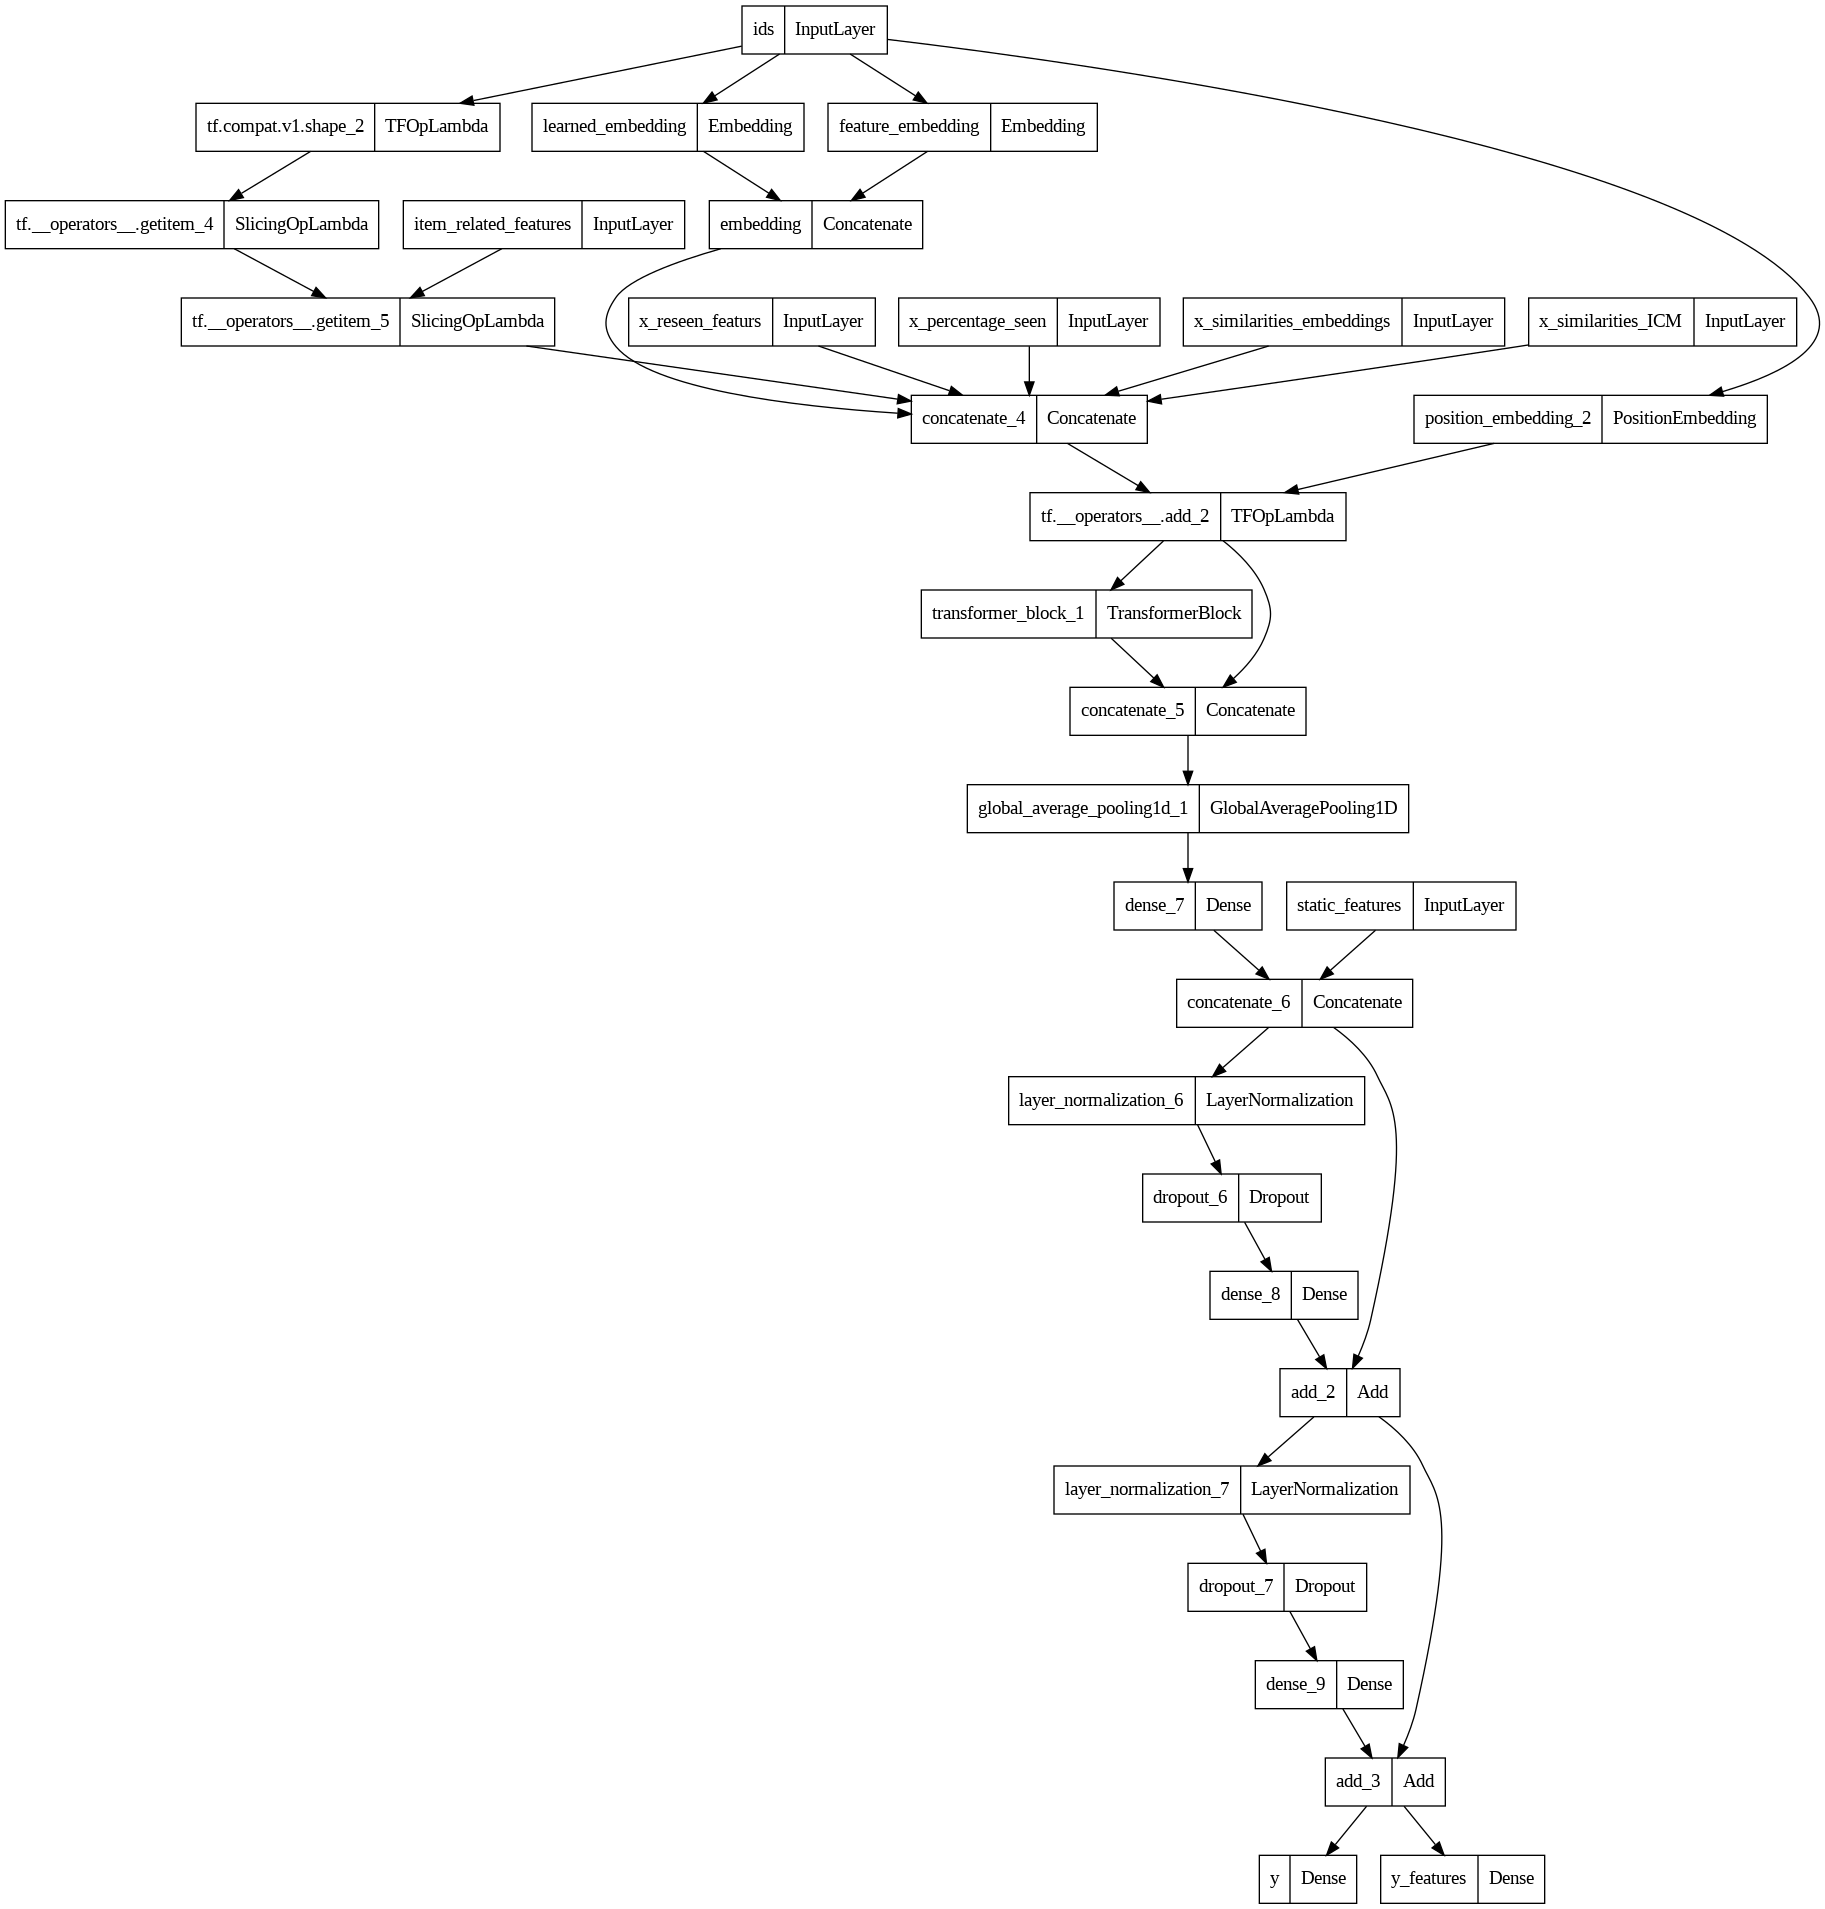

In [28]:
tf.keras.utils.plot_model(model_for_training,to_file="./transofmer-NN-model.png",expand_nested=True)

# Training

In [29]:
gc.collect()
if just_checking_integrity:
    n_epochs=2
else:
    n_epochs=100
monitor='val_y_mrr_top'
model_for_training.fit(
    train_set_complete,
    validation_data=test_set_complete,
    epochs=n_epochs,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(
                  monitor=monitor,
                  mode='max',
                  patience=1,
                  min_delta=0.0001,
                  restore_best_weights=True,
              ),
         ]
    )


Epoch 1/100
359/359 [==============================] - 201s 512ms/step - loss: 9.0754 - y_loss: 9.0019 - y_features_loss: 0.0735 - y_mrr_top: 0.0199 - val_loss: 8.5219 - val_y_loss: 8.4983 - val_y_features_loss: 0.0235 - val_y_mrr_top: 0.0308
Epoch 2/100
359/359 [==============================] - 187s 507ms/step - loss: 8.1003 - y_loss: 8.0624 - y_features_loss: 0.0380 - y_mrr_top: 0.0522 - val_loss: 7.7253 - val_y_loss: 7.7045 - val_y_features_loss: 0.0208 - val_y_mrr_top: 0.0767
Epoch 3/100
359/359 [==============================] - 191s 518ms/step - loss: 7.4945 - y_loss: 7.4678 - y_features_loss: 0.0267 - y_mrr_top: 0.0932 - val_loss: 7.3744 - val_y_loss: 7.3574 - val_y_features_loss: 0.0169 - val_y_mrr_top: 0.1061
Epoch 4/100
359/359 [==============================] - 187s 506ms/step - loss: 7.1900 - y_loss: 7.1700 - y_features_loss: 0.0199 - y_mrr_top: 0.1188 - val_loss: 7.1896 - val_y_loss: 7.1748 - val_y_features_loss: 0.0148 - val_y_mrr_top: 0.1253
Epoch 5/100
359/359 [=======

KeyboardInterrupt: 

# Prepare candidates last month

In [ ]:
submission_set = tf.data.Dataset.from_tensor_slices(
    (
        x_session_ids_last_month,
     (
        x_ids_last_month,
        x_reseen_last_month/100,
        x_percentage_seen_last_month,
        x_simils_last_month,
        x_simils_feats_last_month,
        x_item_related_last_month,
        static_features_last_month
     )
    )
).batch(128)
submission_set.element_spec

(TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 (TensorSpec(shape=(None, 100), dtype=tf.int32, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float64, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100, 1), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 28), dtype=tf.float64, name=None)))

In [ ]:
submission_df = pd.DataFrame(
    {
        'session_id':[],
        'code':[],
        'score':[],
        'rank':[]
    }
)

submission_df.head()

,session_id,code,score,rank


In [ ]:
candidates=np.unique(y_last_month) # this is for the test month

In [ ]:
candidates

array([  70,   99,  242,  500,  519,  554,  605,  806,  834,  872, 1183,
       1281, 1368, 1382, 1428, 1440, 1463, 1465, 1605, 1609, 1671, 1727,
       1790, 1794, 1813, 1972, 2037, 2202, 2276, 2347, 2376, 2381, 2450,
       2483, 2498, 2620, 2638, 2694, 2696, 2725, 2906, 3094, 3186, 3287,
       3460, 3539, 3732, 3815, 3833, 3879, 3885, 3949, 4138, 4167, 4170,
       4385, 4436, 4451, 4503, 4542, 4579, 4681, 4694, 4726, 4913, 4942],
      dtype=int64)

In [ ]:
for session_ids, sessions in submission_set:
    predicted_scores=model_for_training(sessions)[0].numpy()
    mask = np.ones(predicted_scores.shape[1], dtype=bool)
    mask[candidates] = False
    predicted_scores[...,mask]=-np.inf
    predicted_scores=tf.convert_to_tensor(predicted_scores)
    preds=tf.math.top_k(predicted_scores, k=100)
    scores=preds.values.numpy()
    code = preds.indices.numpy()
    prediction = pd.DataFrame(
        {
            'session_id':session_ids,
            'code':[tuple(v) for v in code],
            'score':[tuple(v) for v in scores],
            'rank':[tuple([rank for rank in range(1, 101)]) for id in session_ids]
        }
        )

    submission_df = pd.concat([submission_df, prediction])

submission_df.head()

,session_id,code,score,rank
0,918743.0,"(1609, 2276, 4167, 3879, 2694, 554, 1790, 1794...","(0.00048415796, 0.00028295998, 0.0001824627, 0...","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,920476.0,"(1609, 2276, 4167, 3879, 554, 2694, 1794, 3732...","(0.00053957273, 0.00023988076, 0.0001907269, 0...","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,920582.0,"(1609, 2276, 4167, 3879, 554, 2694, 1794, 3732...","(0.00054139504, 0.00024285277, 0.00018871212, ...","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,920773.0,"(1609, 2276, 4167, 3879, 2694, 554, 1794, 4942...","(0.00050465367, 0.00024024707, 0.00018257722, ...","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,922491.0,"(1609, 2276, 4167, 3879, 2694, 554, 1790, 1794...","(0.0005144957, 0.00028004654, 0.00018156112, 0...","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [ ]:
submission_df.to_csv(
    './dataset/candidates/NN/Transformer/train/candidates.csv',
    index=False
    )